In [1]:
from dpp import setup as SETUP
from dpp import collider, fit

import importlib
import numpy as np
import pandas as pd
import random
import time
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
mpl.rcParams['font.family'] = 'monospace'

In [2]:
setup = SETUP.Setup(400, 3)

**Matching css and nlo**

In [4]:
Mtab = [1]
ztab = [0.02, 0.05, 0.95, 0.98]
sample_size = 60
methods = ['css', 'nlo', 'div']
kTmin, kTmax = 0, 3
parametrization = 'SY'

In [5]:
MIdf = None
idx = 0
for z in ztab:
    for M in Mtab:
        print(M, z)
        df = collider.transverse_differential_cross_section(setup, M, z, sample_size, methods,\
                                                    kTmin=kTmin, kTmax=kTmax, parametrization=parametrization,\
                                                    scale='linear', pool_number=6)
        MIdf_ = collider.to_MIdataframe(df, idx)
        MIdf = collider.update_MIdataframe(MIdf, MIdf_)
        idx += 1

In [100]:
def regulation_up(df):
    
    n = len(df)
    nlo, div, css, kT = df['nlo'], df['div'], df['css'], df['kT']
    
    status = 'css'
    reg = [css[0]]    
    for i in range(1, n):
        
        if status == 'css':
            if css[i] > nlo[i]:
                status = 'match'
                y = nlo[i]+css[i]-div[i]
            else:
                y = css[i]
        elif status == 'match':
            if nlo[i] > css[i]:
                status = 'nlo'
                y = nlo[i]
            else:
                y = nlo[i]+css[i]-div[i]
        elif status == 'nlo':
            y = nlo[i]
        else:
            print('problem')
    
        reg.append(y)
    
    return np.array(reg)

def regulation_down(df):
    
    n = len(df)
    nlo, div, css, kT = df['nlo'], df['div'], df['css'], df['kT']
    
    status = 'css'
    reg = [css[0]]    
    for i in range(1, n):
        
        if status == 'css':
            if css[i] > nlo[i]:
                status = 'nlo'
                y = nlo[i]
            else:
                y = css[i]
        elif status == 'nlo':
            y = nlo[i]
        else:
            print('problem')
    
        reg.append(y)
    
    return np.array(reg)

def plot_index(n):
    
    i = n%3
    j = n/3
    
    return i, j

def get_fits(df):
    
    nlo, div, css, kT = df['nlo'], df['div'], df['css'], df['kT']
    fits = dict()
    
    fits['nlo'] = interp1d(kT[1:], nlo[1:], kind='cubic', fill_value='extrapolate')
    fits['div'] = interp1d(kT[1:], div[1:], kind='cubic', fill_value='extrapolate')
    fits['css'] = interp1d(kT, css, kind='cubic', fill_value='extrapolate')
    
    return fits

In [164]:
reload(fit)
fits = get_fits(df)
fit.get_transverse_regularization_fit(fits, kTmin, kTmax, a1=4., a2=20., n=int(1E3))

<IPython.core.display.Javascript object>


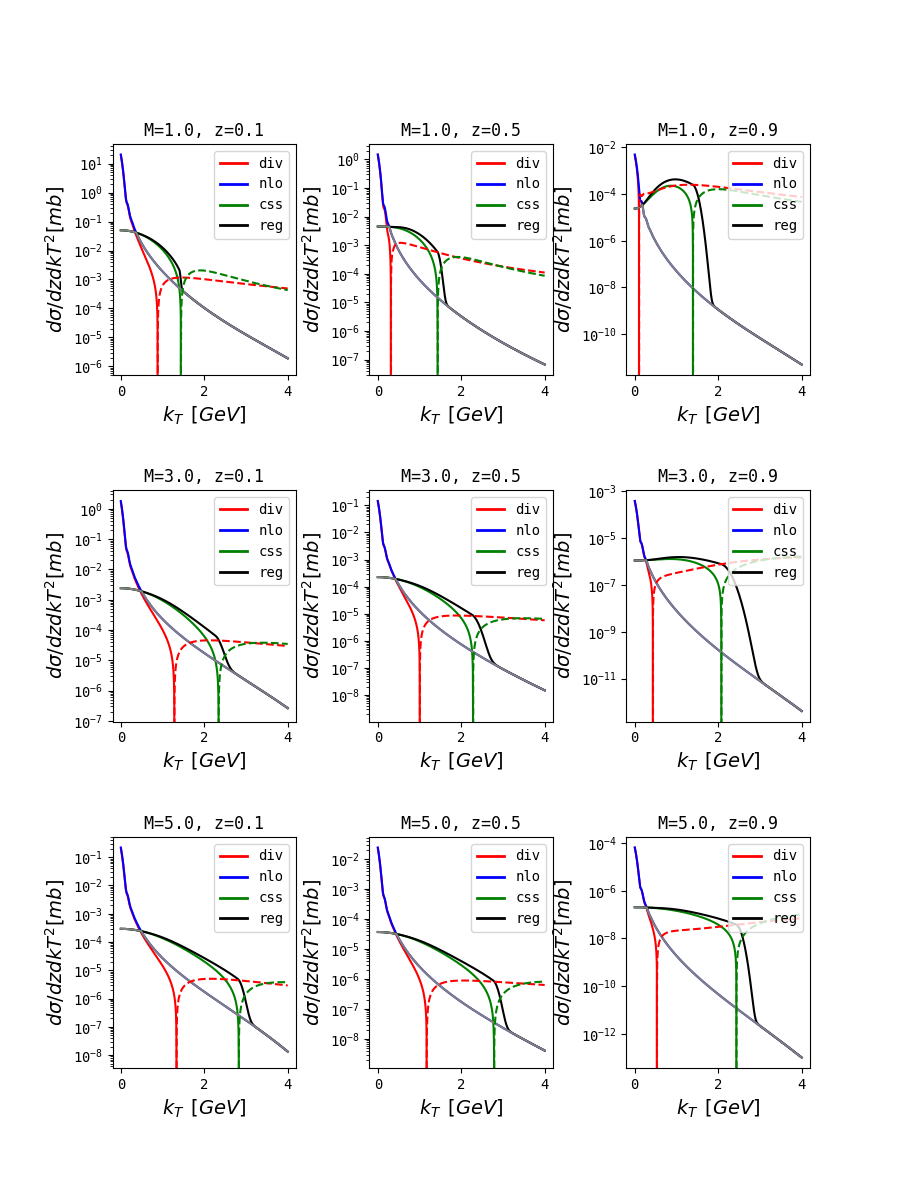

In [165]:
%matplotlib notebook

legends = [Line2D([0], [0], color='r', lw=2, label='div'),
           Line2D([0], [0], color='b', lw=2, label='nlo'),
           Line2D([0], [0], color='g', lw=2, label='css'),
           Line2D([0], [0], color='k', lw=2, label='reg')]

fig, ax = plt.subplots(3, 3, figsize=(9, 12))

for n in range(9):
    i, j = plot_index(n)
    df = MIdf1[n]
    fits = get_fits(df)
    kTmin, kTmax = 0, 4
    fit.get_transverse_regularization_fit(fits, kTmin, kTmax, a1=4., a2=20., n=int(1E3)) 
    
    kT = np.linspace(0, 4, 1000)
    css = fits['css'](kT)
    nlo = fits['nlo'](kT)
    div = fits['div'](kT)
    reg_sup = fits['reg_sup'](kT)
    reg_inf = fits['reg_inf'](kT)
    
    #ax[i,j].plot(df['kT'], df['div'], color='r', Linestyle='None', marker='+')
    #ax[i,j].plot(df['kT'], df['nlo'], color='b', Linestyle='None', marker='+')
    #ax[i,j].plot(df['kT'], df['css'], color='g', Linestyle='None', marker='+')
    #ax[i,j].plot(df['kT'], -df['div'], color='r', Linestyle='None', marker='+')
    #ax[i,j].plot(df['kT'], -df['nlo'], color='b', Linestyle='None', marker='+')
    #ax[i,j].plot(df['kT'], -df['css'], color='g', Linestyle='None', marker='+')
    
    ax[i,j].plot(kT, div, color='r', Linestyle='-')
    ax[i,j].plot(kT, nlo, color='b', Linestyle='-')
    ax[i,j].plot(kT, css, color='g', Linestyle='-')
    ax[i,j].plot(kT, reg_sup, color='k', Linestyle='-')
    ax[i,j].plot(kT, reg_inf, color='gray', Linestyle='-')
    ax[i,j].plot(kT, -div, color='r', Linestyle='--')
    ax[i,j].plot(kT, -nlo, color='b', Linestyle='--')
    ax[i,j].plot(kT, -css, color='g', Linestyle='--')
    ax[i,j].plot(kT, -reg_sup, color='k', Linestyle='--')
    ax[i,j].plot(kT, -reg_inf, color='gray', Linestyle='--')

    ax[i,j].set(xscale='linear', yscale='log')
    ax[i,j].set_xlabel('$k_T\:\:[GeV]$', fontsize=14)
    ax[i,j].set_ylabel('$d\sigma/dzdkT^2 [mb]$', fontsize=14)
    ax[i,j].set_title('M={}, z={}'.format(df.at[0,'M'], df.at[0,'z']))
    ax[i,j].legend(handles=legends, loc='upper right')
    
plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()

In [103]:
fits = get_fits(df)

In [123]:
n_points = [int(10**x) for x in range(8)]
comp_time = list()
for n in n_points:
    kT = np.linspace(0, 3, n)
    tic = time.time()
    fits['css'](kT)
    tac = time.time()
    comp_time.append((tac-tic)/n)

<IPython.core.display.Javascript object>


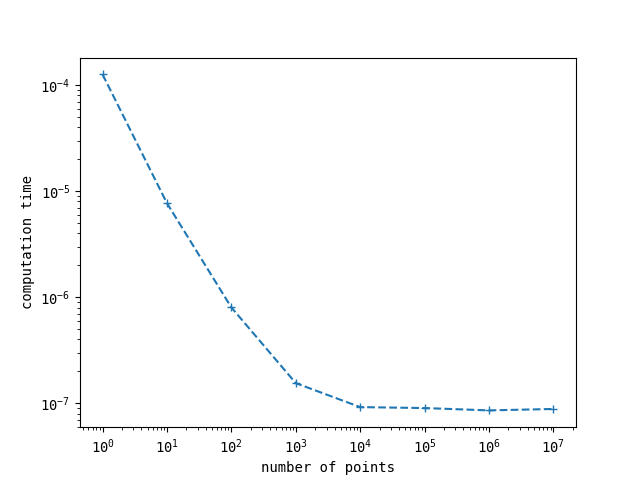

In [124]:
fig, ax = plt.subplots()

ax.plot(n_points, comp_time, marker='+', Linestyle='--')
ax.set_xlabel('number of points')
ax.set_ylabel('computation time')
ax.set(xscale='log', yscale='log')

plt.show()

In [33]:
MIdf.to_pickle('/home/jonas/Documents/DarkPhotonProduction/darkphoton/data/regulation1.pkl')

In [36]:
MIdf1 = pd.read_pickle('/home/jonas/Documents/DarkPhotonProduction/darkphoton/data/regulation1.pkl')